# Calibrating pulses on `ibmq_bogota`

The following notebook, and the corresponding code in [calibration_utils.py](../src/calibration_utils.py), has been wholly lifted and butchered from a [Section 6.2](./accessing_higher_energy_states.ipynb) of the
[qiskit textbook](https://qiskit.org/textbook/preface.html).
See the textbook for more details on the method presented here.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.calibration_utils import *
from src.plotting_utils import *

In this notebook we will look at calibrating pulses on `ibmq_bogota`.
Unlike `ibmq_armonk`, this device has multiple qubits.
This fact will lead to some very interesting (and annoying) differences in the calibration procedure.

In [2]:
calibration = Calibration(
    backend_name='ibmq_bogota',
    qubit_idx=2,
    num_shots=8000,
    scale_factor=1e-6
)

Qubit 2 has an estimated frequency of 4.7829352997606795 GHz.


## Calibrating a pulse for the $|0\rangle \leftrightarrow |1\rangle$ transition

### Frequency sweep

In [18]:
num_freqs = 75
ground_freq_sweep = calibration.default_qubit_freq + np.linspace(-5*MHz, 5*MHz, num_freqs)

ground_freq_sweep_job = calibration.run_ground_freq_sweep_program(
    freqs=ground_freq_sweep,
    drive_power=0.1
)

The frequency sweep will go from 4.77793529976068 GHz to 4.787935299760679 GHz using 75 frequencies. The drive power is 0.1.
Job ID: 61010957be50790d732b2ea5
Job Status: job has successfully run


In [19]:
ground_freq_sweep_data = get_job_data(
    ground_freq_sweep_job,
    average=True,
    qubit_idx=calibration.qubit,
    scale_factor=calibration.scale_factor
)

In [20]:
(ground_sweep_fit_params, ground_sweep_y_fit) = fit_function(
    ground_freq_sweep,
    ground_freq_sweep_data,
    lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
    [7, calibration.default_qubit_freq, 0.1*GHz, 3*GHz] # Initial parameters for curve_fit
)

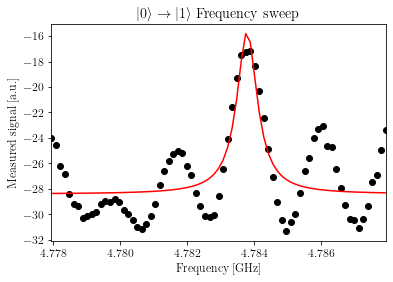

In [21]:
plt.scatter(ground_freq_sweep/GHz, ground_freq_sweep_data, color='black')
plt.plot(ground_freq_sweep/GHz, ground_sweep_y_fit, color='red')

plt.xlim([min(ground_freq_sweep/GHz), max(ground_freq_sweep/GHz)])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Measured signal [a.u.]')
plt.title(r'$|0\rangle \rightarrow |1\rangle$ Frequency sweep')

plt.show()

As we can see, the frequency sweep on the drive line lights up a series of resonances in the spectrum.
This makes it harder to find an accurate maximum.
Nevertheless, let's see how a Rabi experiment performs.

In [22]:
_, cal_qubit_freq, _, _ = ground_sweep_fit_params
print(f"We've updated our qubit frequency estimate from "
      f"{round(calibration.default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 4.7829353 GHz to 4.7837858 GHz.


### Rabi experiment

In [23]:
num_rabi_points = 50

drive_amp_min = 0
drive_amp_max = 0.05
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [24]:
rabi_01_job = calibration.run_rabi_01_program(
    cal_qubit_freq=cal_qubit_freq,
    drive_amps=drive_amps
)

Job ID: 61010a1491714fc09328d637
Job Status: job has successfully run


We fit the data to a sinusoid:

In [25]:
rabi_01_data = get_job_data(
    rabi_01_job,
    average=True,
    qubit_idx=calibration.qubit,
    scale_factor=calibration.scale_factor
)

In [26]:
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, rabi_01_y_fit) = fit_function(
    drive_amps,
    rabi_01_data,
    lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*x/drive_01_period - phi) + B),
    [1.5, -1.5, 0.04, 0]
)

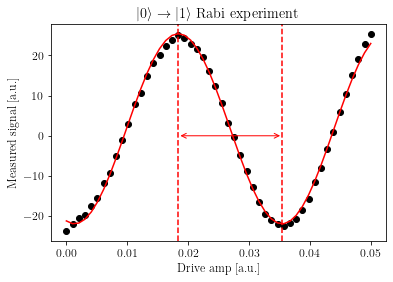

In [27]:
plt.scatter(drive_amps, rabi_01_data, color='black')
plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2]
pi_amp_01 = (drive_01_period/2/np.pi) * (np.pi + rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel('Drive amp [a.u.]')
plt.ylabel('Measured signal [a.u.]')
plt.title(r'$|0\rangle \rightarrow |1\rangle$ Rabi experiment')

plt.show()

Not too bad! Though the power needs to be brought down very low.

In [28]:
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.018396363104025388


In [29]:
pi_pulse_01 = pulse_lib.gaussian(
    duration=calibration.drive_samples,
    amp=pi_amp_01,
    sigma=calibration.drive_sigma,
    name='pi_pulse_01'
)

## Calibrating a pulse for the $|1\rangle \leftrightarrow |2\rangle$ transition

### Frequency sweep

In [30]:
anharmonicity = calibration.backend.properties().qubits[calibration.qubit][3].to_dict()['value'] * GHz

In [31]:
num_freqs = 75
excited_freq_sweep = cal_qubit_freq + anharmonicity + np.linspace(-10*MHz, 10*MHz, num_freqs)

In [32]:
excited_freq_sweep_job = calibration.run_excited_freq_sweep_program(
    freqs=excited_freq_sweep,
    cal_qubit_freq=cal_qubit_freq,
    pi_pulse_01=pi_pulse_01,
    drive_power=0.1
)

The frequency sweep will go from 4.430913333465279 GHz to 4.450913333465278 GHz using 75 frequencies. The drive power is 0.1.
Job ID: 61010e13be507914042b2ead
Job Status: job has successfully run


In [33]:
# Get job data (average)
excited_freq_sweep_data = get_job_data(
    excited_freq_sweep_job,
    average=True,
    qubit_idx=calibration.qubit,
    scale_factor=calibration.scale_factor
)

In [34]:
(excited_sweep_fit_params, excited_sweep_y_fit) = fit_function(
    excited_freq_sweep,
    excited_freq_sweep_data,
    lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
    [-12, 4.625*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
)

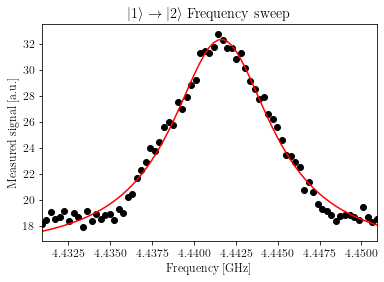

In [35]:
plt.scatter(excited_freq_sweep/GHz, excited_freq_sweep_data, color='black')
plt.plot(excited_freq_sweep/GHz, excited_sweep_y_fit, color='red')

plt.xlim([min(excited_freq_sweep/GHz), max(excited_freq_sweep/GHz)])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Measured signal [a.u.]')
plt.title(r'$|1\rangle \rightarrow |2\rangle$ Frequency sweep')

plt.show()

In [36]:
_, qubit_12_freq, _, _ = excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.4416332 GHz.


### Rabi experiment

Finally, we can calibrate a $\pi$ pulse for the $|1\rangle \leftrightarrow |2\rangle$ transition.

In [38]:
num_rabi_points = 75

drive_amp_min = 0
drive_amp_max = 0.2
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [39]:
rabi_12_job = calibration.run_rabi_12_program(
    cal_qubit_freq=cal_qubit_freq,
    pi_pulse_01=pi_pulse_01,
    qubit_12_freq=qubit_12_freq,
    drive_amps=drive_amps
)

Job ID: 610110d13301caf2bfb11ab5
Job Status: job has successfully run


In [40]:
rabi_12_data = get_job_data(
    rabi_12_job,
    average=True,
    qubit_idx=calibration.qubit,
    scale_factor=calibration.scale_factor
)

In [46]:
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, rabi_12_y_fit) = fit_function(
    drive_amps,
    rabi_12_data,
    lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
    [3, 0.5, 0.075, 0]
)

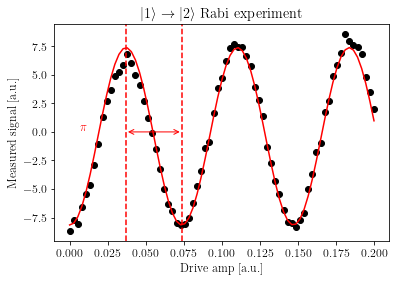

In [48]:
plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel('Drive amp [a.u.]')
plt.ylabel('Measured signal [a.u.]')
plt.title(r'$|1\rangle \rightarrow |2\rangle$ Rabi experiment')
plt.show()

In [49]:
print(f"Our updated estimate for the 1->2 transition frequency is "f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.4416332 GHz.
Pi Amplitude (1->2) = 0.036999752657466696


In [50]:
pi_pulse_12 = pulse_lib.gaussian(
    duration=calibration.drive_samples,
    amp=pi_amp_12,
    sigma=calibration.drive_sigma,
    name='pi_pulse_12'
)
pi_pulse_12 = calibration.apply_sideband(pi_pulse_12, qubit_12_freq, cal_qubit_freq)

Not too bad!
There's clearly a lot more going on with this device, but we got some pretty good fits onto the data.